In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib as mpl

from os.path import join

plt.style.use(["seaborn", "thesis"])

In [22]:
plt.rc("figure",figsize=(8, 4))

# Molecule 

In [23]:
from SCFInitialGuess.utilities.dataset import Molecule

angle_HCC = 121.3/180 *np.pi
distance_CC = 1.339
distance_CH = 1.087

mol = Molecule(
    species=["C", "C", "H", "H", "H", "H"],
    positions=[
        [ 0.00000,       0.00000,        0.00000],
        [ distance_CC  ,       0.00000,        0.00000],
        [ distance_CH * np.cos(angle_HCC), distance_CH * np.sin(angle_HCC), 0.00000],
        [ distance_CH * np.cos(2*np.pi - angle_HCC), distance_CH * np.sin(2*np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(np.pi - angle_HCC), distance_CH * np.sin(np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(- np.pi + angle_HCC), distance_CH * np.sin(- np.pi + angle_HCC), 0.00000]
    ]
)

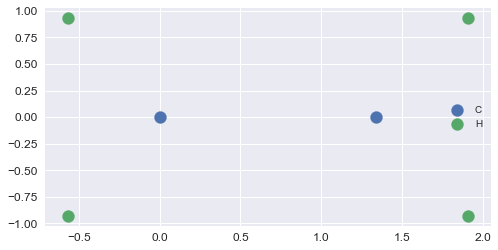

In [24]:
pos = np.array(mol.positions)
plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")
plt.legend()

# Utilities 

In [25]:
def activation(r, phi, theta, descriptor, values):
    
    radial_descriptor = descriptor.radial_descriptor
    angular_descriptor = descriptor.angular_descriptor
    
    return radial_descriptor.calculate_inverse_descriptor(
        r, 
        values[:radial_descriptor.number_of_descriptors]
    ) * angular_descriptor.calculate_inverse_descriptor(
        r,
        phi,
        theta,
        values[radial_descriptor.number_of_descriptors:]
    ) 

# Initialize Descriptors

## Utilities 

In [26]:
def plot_normal_model(model, t):
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t, np.exp(-1 * eta*(t - r_s)**2))
        
def plot_periodic_model(model, t):
    period = model[2]
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t,
            np.exp(-1 * eta * ((t % period) - r_s)**2) + \
            np.exp(-1 * eta * ((t % period) - period - r_s)**2)
        )

## Low Level 

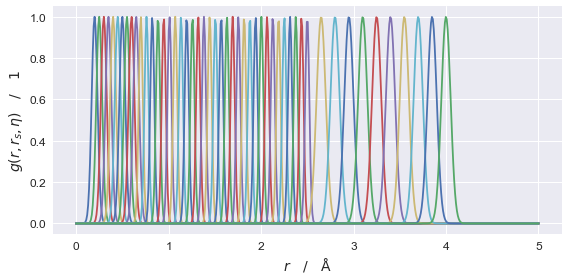

In [27]:
r_model_concentrated = (
    list(np.linspace(0.2, 0.7, 11))[:-1] + \
    list(np.linspace(0.7, 2.5, 30)) + \
    list(np.linspace(2.5, 4, 11))[1:],
    [500]*10 + \
    [1000]*30 + \
    [200]*10,
)

plot_normal_model(r_model_concentrated, np.linspace(0, 5, 500))

plt.ylabel("$g(r, r_s, \eta) \quad \mathrm{ / }\quad 1 $")
plt.xlabel("$r\quad \mathrm{ / } \quad\mathrm{\AA}$")

plt.tight_layout()

plt.savefig("/home/jo/Repos/MastersThesis/AtomicBlocks/figures/RadialModelOrigin.pdf")


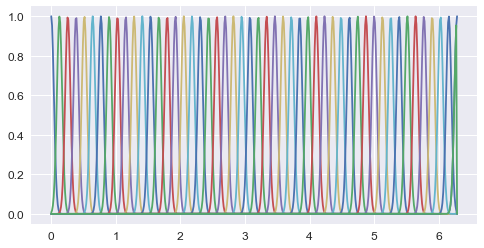

In [28]:
phi_model_evenly = (
    np.linspace(0, 2*np.pi, 50),
    [300] * 50,
    2 * np.pi
)

plot_periodic_model(phi_model_evenly, np.linspace(0, 2 * np.pi, 500))

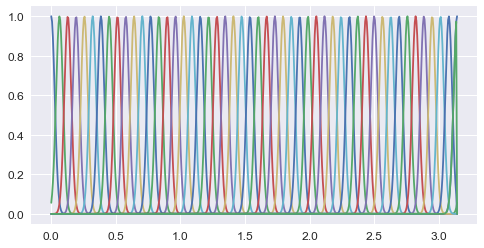

In [29]:
theta_model_evenly = (
    np.linspace(0, np.pi, 50),
    [700] * 50,
    np.pi
)

plot_periodic_model(theta_model_evenly, np.linspace(0, np.pi, 500))

## High Level

In [30]:
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, PeriodicGaussians, IndependentAngularDescriptor
from SCFInitialGuess.descriptors.cutoffs import \
    BehlerCutoff1
from SCFInitialGuess.descriptors.high_level import NonWeighted
    
    
descriptor_concentrated = NonWeighted(
    Gaussians(*r_model_concentrated),
    IndependentAngularDescriptor(
        PeriodicGaussians(*phi_model_evenly),
        PeriodicGaussians(*theta_model_evenly),
    ),
    BehlerCutoff1(5)
)

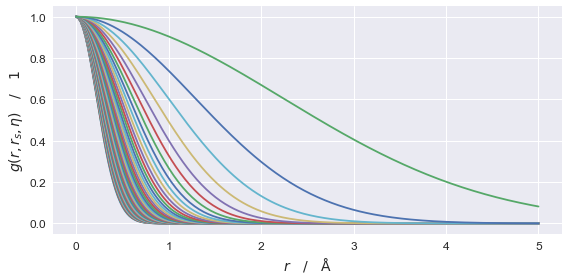

In [31]:
model = (
    [0.0] * 50,
    np.linspace(10, 0.1, 50)
)

descriptor_origin = NonWeighted(
    Gaussians(*model),
    IndependentAngularDescriptor(
        PeriodicGaussians(*phi_model_evenly),
        PeriodicGaussians(*theta_model_evenly),
    ),
    BehlerCutoff1(5)
)
plot_normal_model(model, np.linspace(0, 5, 200))

plt.ylabel("$g(r, r_s, \eta) \quad \mathrm{ / }\quad 1 $")
plt.xlabel("$r\quad \mathrm{ / } \quad\mathrm{\AA}$")

plt.tight_layout()

plt.savefig("/home/jo/Repos/MastersThesis/AtomicBlocks/figures/RadialModelOrigin.pdf")


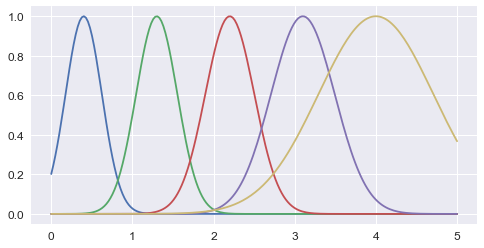

In [32]:
from SCFInitialGuess.descriptors.models import make_uniform

model = make_uniform(5, 5, eta_max=10, eta_min=1)

descriptor_unifrom_radial_5 = NonWeighted(
    Gaussians(*model),
    IndependentAngularDescriptor(
        PeriodicGaussians(*phi_model_evenly),
        PeriodicGaussians(*theta_model_evenly),
    ),
    BehlerCutoff1(5)
)
plot_normal_model(model, np.linspace(0, 5, 200))

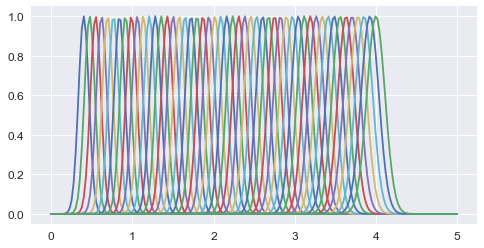

In [33]:
from SCFInitialGuess.descriptors.models import make_uniform

model = make_uniform(50, 5, eta_max=120, eta_min=40)

descriptor_unifrom_radial_50 = NonWeighted(
    Gaussians(*model),
    IndependentAngularDescriptor(
        PeriodicGaussians(*phi_model_evenly),
        PeriodicGaussians(*theta_model_evenly),
    ),
    BehlerCutoff1(5)
)
plot_normal_model(model, np.linspace(0, 5, 200))

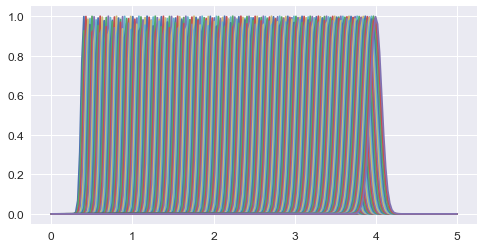

In [34]:
from SCFInitialGuess.descriptors.models import make_uniform

model = make_uniform(250, 5, eta_max=500, eta_min=100)

descriptor_unifrom_radial_250 = NonWeighted(
    Gaussians(*model),
    IndependentAngularDescriptor(
        PeriodicGaussians(*phi_model_evenly),
        PeriodicGaussians(*theta_model_evenly),
    ),
    BehlerCutoff1(5)
)
plot_normal_model(model, np.linspace(0, 5, 200))

## Radial 

In [35]:
def plot_radial_descriptor(r, descriptor, label):
    values = descriptor.calculate_atom_descriptor(
        0,
        mol,
        descriptor.number_of_descriptors
    )
    
    n_radial = descriptor.radial_descriptor.number_of_descriptors
    radial_values = values[:n_radial]
    
    inverse_values = descriptor.radial_descriptor.calculate_inverse_descriptor(r, radial_values)
    
    plt.plot(
        r, 
        inverse_values / np.max(inverse_values),
        label=label
    )
    


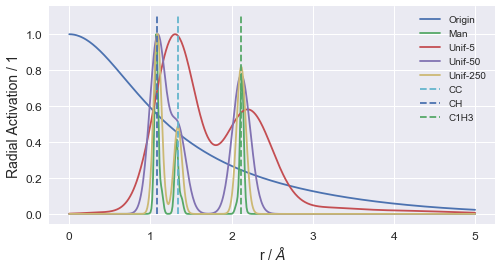

In [36]:
r = np.linspace(0, 5, 500)

plot_radial_descriptor(r, descriptor_origin, "Origin")
plot_radial_descriptor(r, descriptor_concentrated, "Man")
plot_radial_descriptor(r, descriptor_unifrom_radial_5, "Unif-5")
plot_radial_descriptor(r, descriptor_unifrom_radial_50, "Unif-50")
plot_radial_descriptor(r, descriptor_unifrom_radial_250, "Unif-250")


plt.plot([distance_CC]*2, [0, 1.1], "--", label="CC")
plt.plot([distance_CH]*2, [0, 1.1], "--", label="CH")
plt.plot([
    np.sqrt(distance_CH**2 + distance_CC**2 - 2*distance_CH*distance_CC*np.cos(angle_HCC))
]*2, [0, 1.1], "--", label="C1H3")


plt.xlabel("r / $\AA$")
plt.ylabel("Radial Activation / 1")

plt.legend()

plt.savefig("/home/jo/Repos/MastersThesis/AtomicBlocks/figures/RadialActivation.pdf")


## Angular 

In [37]:
from SCFInitialGuess.descriptors.coordinate_descriptors import SPHAngularDescriptor
from SCFInitialGuess.descriptors.models import make_uniform

model = make_uniform(25, 5, eta_max=50, eta_min=10)

descriptor_sph_2 = NonWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(2),
    BehlerCutoff1(5)
)

descriptor_sph_5 = NonWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(5),
    BehlerCutoff1(5)
)

descriptor_sph_15 = NonWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(15),
    BehlerCutoff1(5)
)

In [38]:
def plot_azimuthal_descriptor_pg(phi, descriptor, label):
    values = descriptor.calculate_atom_descriptor(
        0,
        mol,
        descriptor.number_of_descriptors
    )

    n_radial = descriptor.radial_descriptor.number_of_descriptors
    n_azimuthal = descriptor.angular_descriptor.azimuthal_descriptor.number_of_descriptors

    angular_values = values[n_radial:(n_radial+n_azimuthal)]

    inverse_values = descriptor.angular_descriptor.azimuthal_descriptor.calculate_inverse_descriptor(
        phi,
        #r=None,
        #phi=phi,
        #theta=theta,
        y=angular_values
    )
    
    plt.plot(
        phi / (np.pi ),
        inverse_values/np.max(inverse_values),
        label=label
    )


In [39]:
def plot_azimuthal_descriptor_sph(phi, descriptor, label):
    values = descriptor.calculate_atom_descriptor(
        0,
        mol,
        descriptor.number_of_descriptors
    )

    n_radial = descriptor.radial_descriptor.number_of_descriptors

    angular_values = values[n_radial:]

    inverse_values = descriptor.angular_descriptor.calculate_inverse_descriptor(
        r=None,
        phi=phi,
        theta=theta,
        y=angular_values
    )
    
    plt.plot(
        phi / (np.pi ),
        inverse_values/np.max(inverse_values),
        label=label
    )


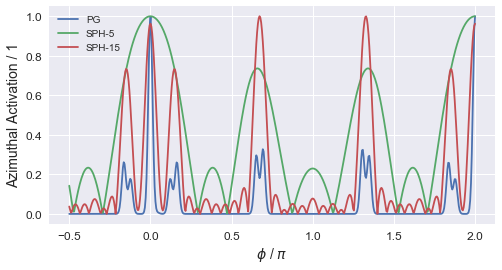

In [42]:
theta = np.pi/ 2

phi = np.linspace(-np.pi*0.5, 2 * np.pi, 500)

plot_azimuthal_descriptor_pg(phi, descriptor_concentrated, "PG")
#plot_azimuthal_descriptor_sph(phi, descriptor_sph_2, "SPH-2")
plot_azimuthal_descriptor_sph(phi, descriptor_sph_5, "SPH-5")
plot_azimuthal_descriptor_sph(phi, descriptor_sph_15, "SPH-15")

#plt.plot([120/180*2]*2, [0, 1.1], label="120 °")
#plt.plot([120/180*2]*2, [0, 1.1], label="-120 °")

plt.xlabel("$\phi$ / $\pi$")
plt.ylabel("Azimuthal Activation / 1")

plt.legend()

plt.savefig("/home/jo/Repos/MastersThesis/AtomicBlocks/figures/AzimuthalActivation.pdf")


## Polar 

In [43]:
n_polar = descriptor.angular_descriptor.polar_descriptor.number_of_descriptors

NameError: name 'descriptor' is not defined

In [45]:
theta = np.linspace(0, np.pi, 500)


plt.plot(
    theta / (np.pi),
    descriptor_concentrated.angular_descriptor.polar_descriptor.calculate_inverse_descriptor(
        theta,
        values[(n_radial + n_azimuthal):]
    )
)

NameError: name 'values' is not defined

## Surface 

In [58]:
descriptor = descriptor_concentrated
values = descriptor.calculate_atom_descriptor(
    0,
    mol,
    descriptor.number_of_descriptors
)

/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


Text(0.5,0,'$\\phi$ / 1/$\\phi$')

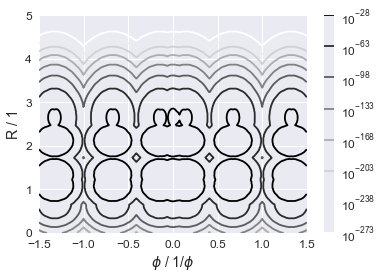

In [59]:
R, Phi = np.meshgrid(r, np.linspace(- 1.5 * np.pi, 1.5 * np.pi, 500))

theta = np.pi / 2

z = activation(
    R.flatten(),
    Phi.flatten(),
    theta,
    descriptor_concentrated,
    values
)


plt.contour(
    Phi / np.pi,
    R,
    z.reshape(*R.shape),
    locator=mpl.ticker.LogLocator()
)
plt.colorbar()
plt.ylabel("R / 1")
plt.xlabel("$\phi$ / 1/$\phi$")

In [60]:
R, Phi = np.meshgrid(
    np.linspace(0, 3, 500), 
    np.linspace(0, 2 * np.pi, 500)
)

theta = np.pi / 2



z = activation(
    R.flatten(),
    Phi.flatten(),
    theta,
    descriptor,
    values
)
th = 1e-10
z[z<=th] = th

In [61]:
plt.rc("figure", figsize=(6,4))

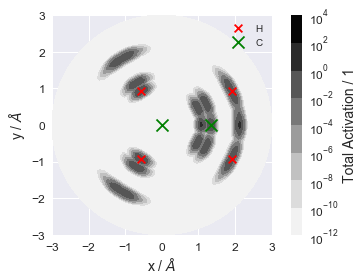

In [71]:
fig, ax = plt.subplots()

plt.contourf(
    (R * np.cos(Phi)),
    (R * np.sin(Phi)),
    z.reshape(*R.shape),
    locator=mpl.ticker.LogLocator()
)



plt.xlabel("x / $\AA$")
plt.ylabel("y / $\AA$")

plt.colorbar(label="Total Activation / 1")

plt.scatter(pos[2:, 0], pos[2:, 1], marker="x", color="r", s=60, label="H")
plt.scatter(pos[:2, 0], pos[:2, 1], marker="x", color="g", label="C")
#plt.scatter(pos[:2, 0], pos[:2, 1], marker="x", color="orange", label="C")


plt.legend()

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#ax = plt.gca()
#ax.set_ylabel=("y / $\AA$")
#ax.set_xlabel=("x / $\AA$")

plt.tight_layout()


plt.savefig("/home/jo/Repos/MastersThesis/AtomicBlocks/figures/XYPlaneActivation.pdf")
